# Table of Contents

1.   [Introduction](#intro)
2.   [Theoretical Analysis](#theory)
3.   [Experiment#1: escaping saddle point](#synthetic)
4.   [Experiment#2: reproducing MNIST results](#mnist)
5.   [Source Code](#source)
6.   [Reference](#reference)


# Team
- Wael
- Ismail
- Oussama Dhifallah
- Donghun Lee, donghunlee@g.harvard.edu

In [0]:
###########################################################################################
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
from mpl_toolkits.mplot3d import Axes3D
import math
from functools import partial
from mpl_toolkits.mplot3d import Axes3D
###########################################################################################

# How to Efficiently Optimize Strict Saddle Functions: Additive Noise Approach

# 1. Introduction 
<a id="intro"></a>
Many estimation problems can be formulated as nonconvex optimization problems. The challenge is that nonconvex problems are generally very hard to solve since the cost function may have an exponential number of stationary points, i.e. local minimizers/maximizers, global minimizers/maximizers and saddle points. One approach to solving nonconvex estimation problems is via a simple gradient descent method, in which case convegence to only a stationary point is guaranteed. 

Nevertheless, many estimation problems have been shown to satisfy the strict saddle property, and almost all the local minima of the cost function have similar objective value to that given by the global minimizers [8,9]. Thus, finding a local minimum would be practically sufficient. Recent literature [2] also shows that if the cost function satisfies the strict saddle property, then the gradient descent method converges to local or global minimizers. 

However, finding a local minimum is very challenging in general using the standard gradient descent method given the nonconvexity of the problem. Reference [3] shows that this simple method may take exponential time to escape strict saddle points. To solve this issue, the authors show that adding noise to the gradient also escapes strict saddle points but in polynomial time. Alternatively, to escape strict saddle points one  can use second-order methods such as the trust region method [4] or Newton's method [5] which guarantee a local minimum [6,7]. 

<!--(References [6,7] show that using a perturbed version of the gradient descent method (such as noisy gradient descent) or a second-order method is sufficient to guarantee local minima.)-->

The present tutorial discusses the methods in [1], which are claimed to reach improved performances when training deep neural networks by adding scheduled Gaussian noise to the gradient. The authors argue that the enhancement occurs in virtue of saddle points/local minima being escaped.  

# 1.1 The Strict Saddle Property 

Consider the optimization problem of minimizing a twice differentiable cost function $f$. We know that the solution of the equation $\nabla f({\bf x})=0$ can be local/global maximizers, local/global maximizers or saddle points. We say that the cost function $f$ satisfies the strict saddle property if the Hessian of every saddle point of $f$ has at least one negative eigenvalue. This means that there is a descent direction at these stationary points. 

Thus, the following is an intuitive explanation of why adding noise to the gradient helps in escaping strict saddle points. Since the gradient vanishes at strict saddle points, adding noise helps to make small progress around strict saddle points. After a few iterations, the gradient descent method is expected to find the descent direction and hence escape the strict saddle points.

# 1.2 Why adding more stochasticity to Stochastic Gradient Descent?

The stochastic gradient descent (SGD) method can be classified as a noisy gradient descent method since it uses an approximation of the gradient based on one sample. This means that one expects that the stochastic gradient descent method is sufficient to escape strict saddle points and converge to a local minimum. In reference [3], the authors provide an in-depth theoretical justification of why adding noise to SGD can be helpful. In that interpretation, finiteness of the dataset, the authors argue, limits the stochasticity of SGD (especially if mini-batches are not used). More precisely, the number of possible values of the noise is exactly the size of the dataset.

Besides, in practice, the data has  stucture: e.g. sparsity for images. Then, the gradient will inherit such structure, making the stochasticity limited. Hence, the noise destroys this bothersome structure and makes the neighborhood of exploration more free.

If we use mini-batches, there are ${n \choose b} \sim n^b $ possibilities and hence more stochasticity than the standard SGD is allowed. Consequently, to fully benefit from the stochasticity offered by using mini-batches, it is useful to change the batch-size from one step to another, thereby yielding the so-called adaptive batch-size method [11]. 

Moreover, the authors show that SGD does not guarantee the presence of noise in every direction. In such a case, SGD may not retrieve the descent direction of the strict saddle points. Adding (the isotropic) Gaussian noise to SGD guarantees noise in every direction. This allows a full exploration of the local neighborhood around the saddle points, thereby enabling the SGD method to find the descent direction of the strict saddle point and escape it.

Some landscapes can make it difficult for gradient descent to escape obstacles like sinuous ravines or flat regions. For instance, in practical situations, the gradient may get stuck in an area where the cost is extremely ill-conditionned, like a deep ravine of the cost function consisting of a local minimum in a subspace defined by the largest eigenvalues of the Hessian matrix of the cost [12]. It has been proven that the Stochastic Gradient Descent has the ability to escape these troublesome situations [14]. Again, since the stochasticity of SGD is limited, especially for small datasets, adding noise can be beneficial in making SGD more powerful.

# 2 The Landscape of the Cost Function in Deep Neural Networks
<a id="theory"></a>
In spite of their effectiveness in learning complex systems, deep neural networks (DNN) have inconvenient highly non-convex loss functions that makes their minimiziation hard, at least in theory. However, this seemingly hard task can be surprisingly easy in some practical examples, where the landscape is characterized by the presence of largely convex regions. In fact, the authors in [15] analysed several examples of DNN and observed that the cost function is approximately convex in the direction between the initialization $\theta_i$ and the final parameter after training $\theta_f$, that is, the function $t \mapsto f(t\theta_i+(1-t)\theta_f)$ decreases smoothly and monotonically from $0$ to $1$. It is also visualized that there is an important negative trajectory curvature in the first steps of the training, and that SGD does not seem to have any difficulty escaping the saddle point near the origin. This is possibly due to the fact that SGD naturally avoids saddle points when the stepsize is sufficiently small.

Furtheremore, The optimization trajectories are embedded in a low dimensional subspace [16]. This conservative behavior can be convenient if $\theta_f-\theta_i$ lies in this subspace, but most optimization methods including SGD often stray from this optimistic direction. Hence, adding noise may potentially increase the dimension of the subspace, by encouraging exploration of new directions, and therefore having higher chances of hitting the right one.

This goes without saying that the success of trainability of deep neural networks using SGD (or other optimization methods) is highly dependent on their architecture, choice of the initialization and the choice of non-linear processing. Finally, to the best of our knowledge, it is still an open question in the literature why the training of large models using SGD remains slow despite the scarcity of pathological areas.

<!--There are a lot of tentitive characterizations of the cost function in deep neural network [16], but one has to admit that the current state of the art is far from being complete-->




# 2.1 Noise Scheduling
An important issue we need to address when adding noise to the SGD method is finding the right amount of noise that guarantees convergence and allows the SGD method to escape strict saddle points.  The *standard* SGD has the following update
$$\theta_{t+1}:=\theta_{t}+\alpha_t \nabla_\theta J_i(\theta_t)$$
Whereas the noisy SGD adds noise to the gradient and hence makes SGD more stochastic than the SGD:
$$\theta_{t+1}:=\theta_{t}+\alpha_t \big(\nabla_\theta J_i(\theta_t)+n_t\big), \quad \text{ where } n_t\sim \mathcal{N}(0,\sigma_t^2)$$
Hence, the noise will be further amplified by the stepsize $\alpha_t$.
In reference [1], the authors assume that the variance of the noise is given by:
$$\sigma_t^2=\frac{\eta}{(1+t)^\gamma}$$
Where $\eta\in\{0.01,0.3,1.0\}$ and $\gamma=0.55$. </br>

The authors in [1] did not justify the choice $\gamma=0.55$. However, they refer to the paper [10] where it was mentioned that the step-size of a Robbins–Monro-inspired algorithm should satisfy the following:
<!--but it is well-known in the literature of SGD that a necessary condition for convergence to a local minimum is -->
$$\sum_t \alpha_t =\infty \quad \text{ and } \quad \sum_t \alpha_t^2<\infty$$
It is worth mentioning that the same regularity condition also applies for SGD to guarentee convergence [12]. Intuitively, the infinite first-moment constraint ensures that we can explore regions that are far from the initialization. On the other hand, the finite second moment constraint ensures convergence to a local minimum instead of flactuating around it. 

Thus, although the authors of [1] use a constant stepsize which does not guarantee convergence, convergence can be guaranteed by specifiying, e.g., $\alpha_t = \sigma_t^2$ where $\sigma_t^2$ is as above for any $\gamma\in (0.5,1].$ This is because, then,
$$\sum_t \frac{\eta}{(1+t)^\gamma} =\infty \quad \text{ and } \quad \sum_t \left(\frac{\eta}{(1+t)^\gamma}\right)^2<\infty$$
for $\gamma \in (0.5,1]$.

# 3 A two dimensional example 
<a id="synthetic"></a>

To illustrate the above theoretical analysis, we consider a simple example similar to the one given in [13]. Specifically, we consider a simple optimization problem in order to compare the performance of gradient descent and noisy gradient descent. Consider the problem of minimizing the following cost function
$$
f(x,y)=\sum_{i=1}^{m} \lambda_i x^2 + \sum_{i=1}^{m} \beta_i y^4 - \sum_{i=1}^{m} \zeta_i y^2
$$
where $\lambda_i \geq 0$, $\beta_i \geq 0$ and $\zeta_i \geq 0$ have i.i.d. uniform distribution. Note that the cost function $f$ is twice differentiable. The gradient of the cost function $f$ can be expressed as follows
$$
\nabla f(x,y)=
\begin{bmatrix}
    2 \sum_{i=1}^{m} \lambda_i x        \\
    4 \sum_{i=1}^{m} \beta_i y^3 - 2 \sum_{i=1}^{m} \zeta_i y        
\end{bmatrix}
$$
Note that the solutions of the equation $\nabla f(x,y)=0$ are the set of stationary points of the cost function $f$. The solutions of this equation are
$$
s_1^\star=
\begin{bmatrix}
    0       \\
    0       
\end{bmatrix}
$$
and 
$$
s_2^\star=
\begin{bmatrix}
    0       \\
    \sqrt{ \frac{\sum_{i=1}^{m} \zeta_i}{2 \sum_{i=1}^{m} \beta_i} }       
\end{bmatrix}
$$
and 
$$
s_3^\star=
\begin{bmatrix}
    0       \\
    -\sqrt{ \frac{\sum_{i=1}^{m} \zeta_i}{2 \sum_{i=1}^{m} \beta_i} }       
\end{bmatrix}
$$
The Hessian of the cost function $f$ can be expressed as follows
$$
\nabla^2 f(x,y)=
\begin{bmatrix}
    2 \sum_{i=1}^{m} \lambda_i & 0       \\
    0 & 12 \sum_{i=1}^{m} \beta_i y^2 - 2 \sum_{i=1}^{m} \zeta_i         
\end{bmatrix}
$$
Note that the Hessian at $s_1^\star$ is diagonal with diagonal entries $2 \sum_{i=1}^{m} \lambda_i > 0$ and $- 2 \sum_{i=1}^{m} \zeta_i < 0$. This means that $s_1^\star$ is a strict saddle point. Now, the Hessian at $s_2^\star$ and $s_3^\star$ is diagonal with diagonal entries $2 \sum_{i=1}^{m} \lambda_i > 0$ and  $4 \sum_{i=1}^{m} \zeta_i >0$. This means that $s_2^\star$ and $s_3^\star$ are local minima. 

Next, we solve the problem of minimizing the cost function $f$ using four techniques:

1- Gradient descent

2- Noisy gradient descent

3- Stochastic gradient descent

4- Noisy stochastic gradient descent

** Generate the data **

In [0]:
###########################################################################################
m=1000
lam=np.random.uniform(0,1,m)
beta=np.random.uniform(0,1,m)
zeta=np.random.uniform(0,1,m)
###########################################################################################

** Define the cost function $f$ and its gradient $\nabla f$ **

In [0]:
###########################################################################################
def fun(x,y,lam,beta,zeta):
    return 1/m*np.sum( lam*x**2+beta*y**4-zeta*y**2 )
###########################################################################################
def g_f1(x,y,lam):
    return 1/m*np.sum( 2*lam*x )
###########################################################################################
def g_f2(x,y,beta,zeta):
    return 1/m*np.sum( 4*beta*y**3-2*zeta*y )
###########################################################################################

** Visualization of the cost function $f$ **

Text(0.5,0,'$y$')

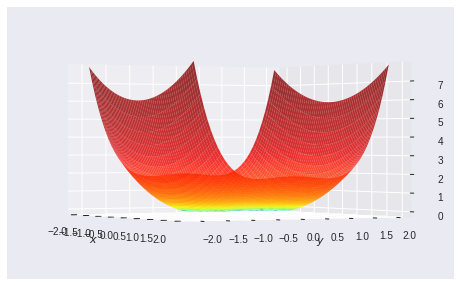

In [0]:
###########################################################################################
ms = np.linspace(-2,2,60)
bs = np.linspace(-2,2,60)
###########################################################################################
M,B=np.meshgrid(ms, bs)
zs=np.array([fun(z[0],z[1],lam,beta,zeta) for z in zip(np.ravel(M), np.ravel(B))])
Z=zs.reshape(M.shape)
########################################################################################### 
fig = plt.figure(figsize=(8, 5))
ax=plt.axes(projection='3d', elev=0, azim=-30)
ax.plot_surface(M, B, Z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
###########################################################################################
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
###########################################################################################

The above plot shows that the cost function is indeed nonconvex, and that it has two local minimizers.

** Visualization of the stationary points of the cost function $f$ **

The local minimizers of the cost function f are
[0, 0.7085014863239425]
[0, -0.7085014863239425]


Text(0.5,0,'$y$')

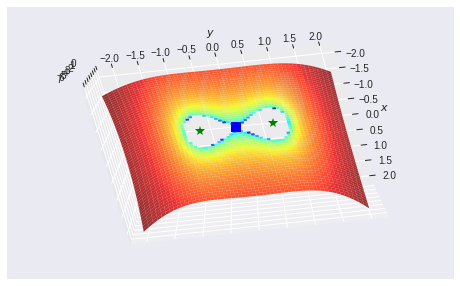

In [0]:
###########################################################################################
l=np.sqrt(np.sum(zeta)/(2*np.sum(beta)))
print('The local minimizers of the cost function f are')
print([ 0 , l]) 
print([ 0 , -l]) 
########################################################################################### 
fig = plt.figure(figsize=(8, 5))
ax=plt.axes(projection='3d', elev=100, azim=-10)
ax.plot_surface(M, B, Z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
###########################################################################################
ax.plot([0] , [0] , fun(0,0,lam,beta,zeta), 'bs', markersize=10)
ax.plot([0], [l], fun(0,l,lam,beta,zeta), 'g*', markersize=10)
ax.plot([0], [-l], fun(0,-l,lam,beta,zeta), 'g*', markersize=10)
###########################################################################################
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
###########################################################################################

** The gradient descent algorithm **

In [0]:
#################################### Gradient Descent ###############################
def gd(z_init, maxsteps, lam , beta, zeta, step=0.001, precision=0.001 ):
    costs=[];iterates=[] 
    z=z_init     
    currentcost=fun(z[0],z[1],lam,beta,zeta)
    oldcost=currentcost;
    costs.append(currentcost)
    iterates.append(z)
    counter=1;error=1;
    while error > precision or counter < maxsteps:
        ######################### Determine the Gradient ############################
        gradient_l1=g_f1(z[0],z[1],lam) 
        gradient_l2=g_f2(z[0],z[1],beta,zeta) 
        gradient=np.array([gradient_l1,gradient_l2])
        ############################ Update \lambda #################################
        z = z - step * gradient  
        #############################################################################
        iterates.append(z) 
        currentcost=fun( z[0],z[1], lam , beta,zeta )
        error=np.linalg.norm(currentcost-oldcost)
        oldcost=currentcost
        costs.append(currentcost)
        #############################################################################
        counter+=1
        if maxsteps:
            if counter == maxsteps:
                break
    #################################################################################
    return iterates, costs
#####################################################################################   

** The noisy gradient descent algorithm **

In [0]:
########################### Noisy Gradient descent  ##################################
def ngd(z_init,maxsteps , lam, beta, zeta, step=0.001, precision=0.001 ):
    costs=[];iterates=[] 
    z=z_init    
    eta=0.01;gamma=0.55;
    currentcost=fun( z[0],z[1],lam,beta,zeta )
    oldcost=currentcost;
    costs.append(currentcost)
    iterates.append(z)
    counter=1;error=1;
    while error > precision or counter < maxsteps:
        ######################### Determine the Gradient ############################
        gradient_l1=g_f1(z[0],z[1],lam) 
        gradient_l2=g_f2(z[0],z[1],beta,zeta) 
        gradient=np.array([gradient_l1,gradient_l2])
        #############################################################################
        sigma= np.sqrt( eta/(1+counter)**gamma )
        noise = np.random.normal(0, sigma , 1)
        ############################ Update \lambda #################################
        z=z - step * ( gradient + noise )  
        #############################################################################
        iterates.append(z) 
        currentcost=fun( z[0],z[1],lam,beta,zeta )
        error=np.linalg.norm(currentcost-oldcost)
        oldcost=currentcost
        costs.append(currentcost)
        #############################################################################
        counter+=1
        if maxsteps:
            if counter == maxsteps:
                break
    #################################################################################
    return iterates, costs
#####################################################################################

** The stochastic gradient descent algorithm **

In [0]:
############################## Stochastic Gradient Descent  ##########################
def sgd(z_init, maxsteps, lam , beta, zeta, step=0.001, precision=0.001 ):
    z = z_init
    costs=[];iterates=[] 
    i=0;epoch=0
    counter=1;error=1;
    currentcost=1
    oldcost=currentcost;
    S=np.random.permutation( np.arange(0,len(lam),1) )
    while error > precision or counter < 1000:
        ######################### Determine the Gradient ############################
        gradient_l1=g_f1( z[0],z[1],lam[S[i]] ) 
        gradient_l2=g_f2( z[0],z[1],beta[S[i]],zeta[S[i]] ) 
        gradient=np.array([gradient_l1,gradient_l2])
        ############################ Update \lambda #################################
        z = z - step * gradient  
        #############################################################################
        currentcost=fun( z[0],z[1],lam,beta,zeta )
        error=np.linalg.norm(currentcost-oldcost)
        oldcost=currentcost
        costs.append(currentcost)           
        i += 1
        if i == len(lam):
            epoch +=1
            S=np.random.permutation( np.arange(0,len(lam),1) )  
            i=0
        #############################################################################
        iterates.append(z) 
        #############################################################################
        counter+=1
        if maxsteps:
            if counter == maxsteps:
                break
        #############################################################################        
    return iterates, costs
#####################################################################################

** The noisy stochastic gradient descent algorithm **

In [0]:
######################### Noisy Stochastic Gradient Descent ##########################
def nsgd(z_init, maxsteps, lam , beta ,zeta , step=0.001, precision=0.001 ):
    z = z_init
    costs=[];iterates=[] 
    i=0;counter=1;
    eta=0.01;gamma=0.55;
    error=1;epoch=0
    currentcost=1
    oldcost=currentcost;
    S=np.random.permutation( np.arange(0,len(lam),1) )
    while error > precision or counter < 1000:
        ######################### Determine the Gradient ############################
        gradient_l1=g_f1( z[0],z[1],lam[S[i]] ) 
        gradient_l2=g_f2( z[0],z[1],beta[S[i]],zeta[S[i]] ) 
        gradient=np.array([gradient_l1,gradient_l2])
        ############################ Update \lambda #################################
        sigma= np.sqrt( eta/(1+counter)**gamma )
        noise = np.random.normal(0, sigma , 1)
        #############################################################################
        z = z - step * ( gradient + noise ) 
        #############################################################################
        currentcost=fun( z[0],z[1],lam,beta,zeta )
        error=np.linalg.norm(currentcost-oldcost)
        oldcost=currentcost
        costs.append(currentcost)           
        i += 1
        if i == len(lam):
            epoch +=1
            S=np.random.permutation( np.arange(0,len(lam),1) )  
            i=0
        #############################################################################
        iterates.append(z) 
        #############################################################################
        counter+=1
        if maxsteps:
            if counter == maxsteps:
                break
        #############################################################################        
    return iterates, costs, 
#####################################################################################  

** Run the gradient descent algorithm with initialization (6,0) **

The solution found using the gradient descent algorithm is [0. 0.]


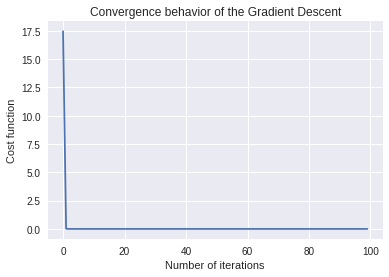

In [0]:
############################# Gradient Descent with step=1 ################################
z_i=np.array( [6,0] )
iterate_gd, cost_gd = gd( z_i, 100000 , lam, beta, zeta, step=1, precision=10**(-20))
###########################################################################################    
print('The solution found using the gradient descent algorithm is',iterate_gd[-1])
plt.plot(range(len(cost_gd[0:100])), (cost_gd[0:100]) );
plt.xlabel('Number of iterations')
plt.ylabel('Cost function')
plt.title('Convergence behavior of the Gradient Descent');
###########################################################################################

In [0]:
###########################################################################################
def make_3d_plot( hist, cost , lam , beta , zeta ):
    ms = np.linspace(-1,6,60)
    bs = np.linspace(-1,1,60)
    ###########################################################################################
    M,B=np.meshgrid(ms, bs)
    zs=np.array([fun(z[0],z[1],lam,beta,zeta) for z in zip(np.ravel(M), np.ravel(B))])
    Z=zs.reshape(M.shape)
    l=np.sqrt(np.sum(zeta)/(2*np.sum(beta)))    
    ########################################################################################### 
    fig = plt.figure(figsize=(8, 5))
    ax=plt.axes(projection='3d', elev=0, azim=-10)
    ax.plot_surface(M, B, Z, norm=LogNorm(), rstride=1, cstride=1, 
                    edgecolor='none', alpha=.8, cmap=plt.cm.jet)
    ax.contour(M, B, Z, 20, color='b', alpha=0.5, offset=0, stride=30)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.view_init(elev=30., azim=140)
    ax.plot([hist[-1][0]], [hist[-1][1]], [cost[-1]] , color='g', markerfacecolor='g', markeredgecolor='g', marker='o', markersize=7);
    ax.plot([t[0] for t in hist], [t[1] for t in hist], cost , color='g', markerfacecolor='g', markeredgecolor='g', marker='.', markersize=7);
    ax.plot([0] , [0] , fun(0,0,lam,beta,zeta), 'bs', markersize=10)
    ax.plot([0], [l], fun(0,l,lam,beta,zeta), 'g*', markersize=10)
    ax.plot([0], [-l], fun(0,-l,lam,beta,zeta), 'g*', markersize=10)
###########################################################################################    
def gd_plot( cost, hist, lam, beta, zeta ):
    make_3d_plot( hist, cost, lam, beta, zeta ) 
###########################################################################################

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


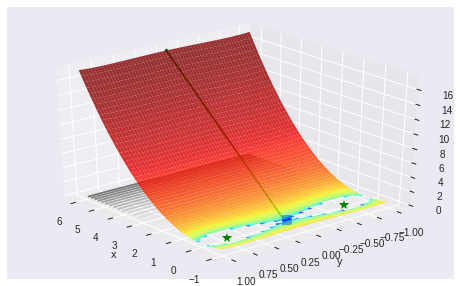

In [0]:
###########################################################################################    
gd_plot( np.array(cost_gd), np.array(iterate_gd), lam, beta, zeta) 
###########################################################################################

It can be noticed that the gradient descent method converges to the saddle point $[0 , 0]$. Although this saddle point is strict, the gradient descent method does not escape it. This is because  gradient descent is unable to explore the neighborhood around this strict saddle point. 

** Run the noisy gradient descent algorithm with initialization (6,0) **

The solution found using the noisy gradient descent algorithm is [-0.00151988  0.71551409]


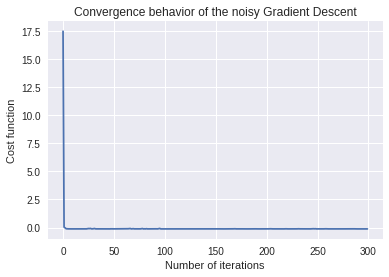

In [0]:
########################### Noisy Gradient Descent with step=1 ############################
z_i=np.array( [6,0] )
iterate_ngd, cost_ngd = ngd( z_i, 100000 , lam, beta, zeta, step=1, precision=10**(-20))
###########################################################################################
print('The solution found using the noisy gradient descent algorithm is',iterate_ngd[-1])
plt.plot(range(len(cost_ngd[0:300])), cost_ngd[0:300]);
plt.xlabel('Number of iterations')
plt.ylabel('Cost function')
plt.title('Convergence behavior of the noisy Gradient Descent');
###########################################################################################

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


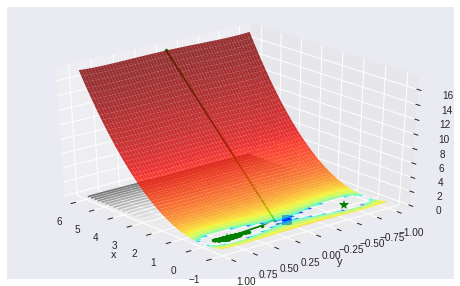

In [0]:
###########################################################################################    
gd_plot( np.array(cost_ngd), np.array(iterate_ngd), lam, beta, zeta) 
###########################################################################################

Note that the noisy gradient descent method converges to a point very close to the global minimizer. It is expected that this method will never reach the global minimizer due to the additive noise.

** Run the stochastic gradient descent algorithm with initialization (6,0) **

The solution found using the stochastic gradient descent algorithm is [4.1659248e-08 0.0000000e+00]


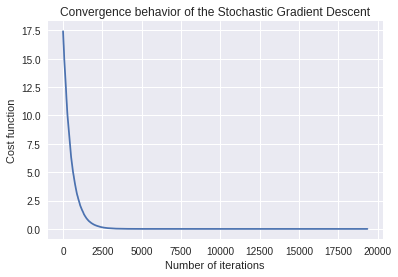

In [0]:
######################## Stochastic Gradient descent with step=1 ##########################
z_i=np.array( [6,0] )
iterate_sgd, cost_sgd = sgd( z_i, 100000 , lam, beta, zeta, step=1, precision=10**(-20))
###########################################################################################
print('The solution found using the stochastic gradient descent algorithm is',iterate_sgd[-1])
plt.plot(range(len(cost_sgd)), cost_sgd);
plt.xlabel('Number of iterations')
plt.ylabel('Cost function')
plt.title('Convergence behavior of the Stochastic Gradient Descent');
###########################################################################################

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


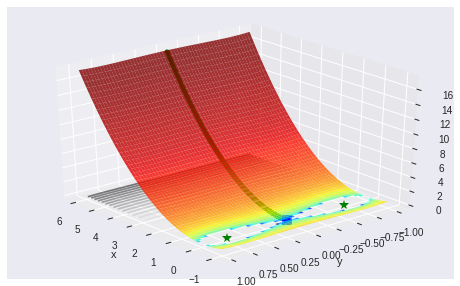

In [0]:
###########################################################################################    
gd_plot( np.array(cost_sgd), np.array(iterate_sgd), lam, beta, zeta) 
###########################################################################################

Note that the stochastic gradient descent method converges to a strict saddle point which is $[0 , 0]$.

** Run the noisy stochastic gradient descent algorithm with initialization (6,0) **

The solution found using the noisy stochastic gradient descent algorithm is [0.03077181 0.69075688]


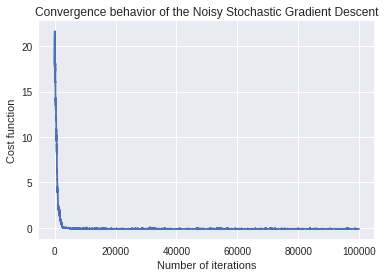

In [0]:
###################### Noisy Stochastic Gradient Descent with step=1 ######################
z_i=np.array( [6,0] )
iterate_nsgd, cost_nsgd = nsgd( z_i, 100000 , lam, beta, zeta, step=1, precision=10**(-20))
###########################################################################################
print('The solution found using the noisy stochastic gradient descent algorithm is',iterate_nsgd[-1])
plt.plot(range(len(cost_nsgd)), cost_nsgd);
plt.xlabel('Number of iterations')
plt.ylabel('Cost function')
plt.title('Convergence behavior of the Noisy Stochastic Gradient Descent');
###########################################################################################

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


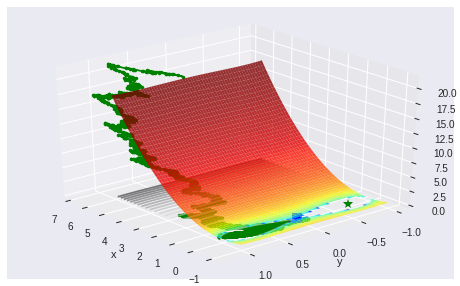

In [0]:
###########################################################################################    
gd_plot( np.array(cost_nsgd), np.array(iterate_nsgd), lam, beta, zeta) 
###########################################################################################

Note that the noisy stochastic gradient descent method escapes the strict saddle point and converges to a point very close to the global minimizer. 

** Run the gradient descent algorithm with initialization (6,1) **

The solution found using the gradient descent algorithm is [0.         0.70850149]


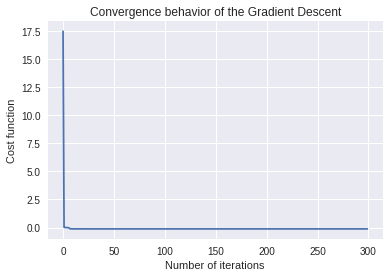

In [0]:
############################## Gradient Descent with step=1 ###############################
z_i=np.array( [6,1] )
iterate_gd2, cost_gd2 = gd( z_i, 100000 , lam, beta, zeta, step=1, precision=10**(-20))
###########################################################################################    
print('The solution found using the gradient descent algorithm is',iterate_gd2[-1])
plt.plot(range(len(cost_gd2[0:300])), (cost_gd2[0:300]) )
plt.xlabel('Number of iterations')
plt.ylabel('Cost function')
plt.title('Convergence behavior of the Gradient Descent');
###########################################################################################

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


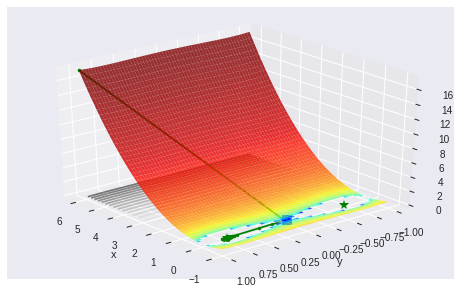

In [0]:
###########################################################################################    
gd_plot( np.array(cost_gd2), np.array(iterate_gd2), lam, beta, zeta) 
###########################################################################################

** Run the noisy gradient descent algorithm with initializations (6,1) **

The solution found using the noisy gradient descent algorithm is [-1.93595549e-04 -7.31519805e-01]


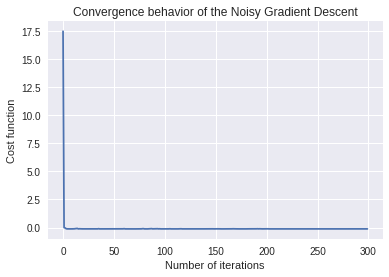

In [0]:
########################## Noisy Gradient Descent with step=1 #############################
z_i=np.array( [6,1] )
iterate_ngd2, cost_ngd2 = ngd( z_i, 100000 , lam, beta, zeta, step=1, precision=10**(-20))
###########################################################################################
print('The solution found using the noisy gradient descent algorithm is',iterate_ngd2[-1])
plt.plot(range(len(cost_ngd2[0:300])), cost_ngd2[0:300]);
plt.xlabel('Number of iterations')
plt.ylabel('Cost function')
plt.title('Convergence behavior of the Noisy Gradient Descent');
###########################################################################################

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


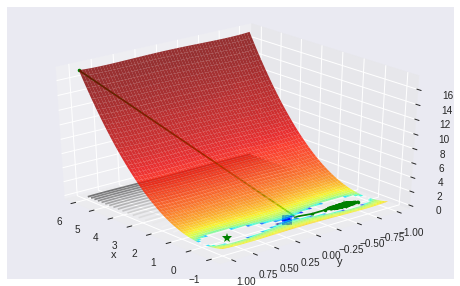

In [0]:
###########################################################################################    
gd_plot( np.array(cost_ngd2), np.array(iterate_ngd2), lam, beta, zeta) 
###########################################################################################

** Run the stochastic gradient descent algorithm with initializations (6,1) **

The solution found using the stochastic gradient descent algorithm is [4.15222854e-42 7.13180268e-01]


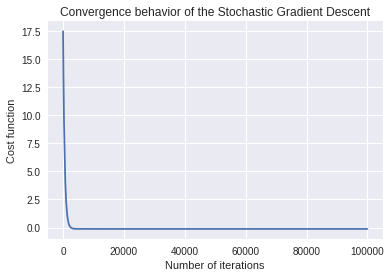

In [0]:
######################## Stochastic Gradient Descent with step=1 ##########################
z_i=np.array( [6,1] )
iterate_sgd2, cost_sgd2 = sgd( z_i, 100000 , lam, beta, zeta, step=1, precision=10**(-20))
###########################################################################################
print('The solution found using the stochastic gradient descent algorithm is',iterate_sgd2[-1])
plt.plot(range(len(cost_sgd2)), cost_sgd2);
plt.xlabel('Number of iterations')
plt.ylabel('Cost function')
plt.title('Convergence behavior of the Stochastic Gradient Descent');
###########################################################################################

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


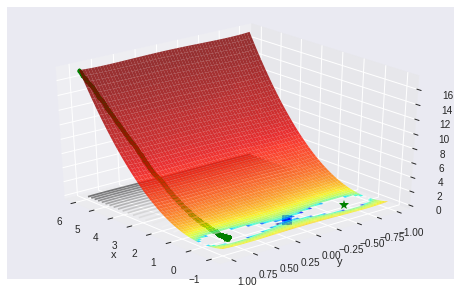

In [0]:
###########################################################################################    
gd_plot( np.array(cost_sgd2), np.array(iterate_sgd2), lam, beta, zeta) 
###########################################################################################

** Run the noisy stochastic gradient descent algorithm with initializations (6,1) **

The solution found using the noisy stochastic gradient descent algorithm is [-0.09035093  0.63775127]


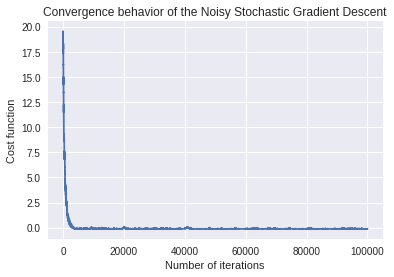

In [0]:
###################### Noisy Stochastic Gradient Descent with step=1 ######################
z_i=np.array( [6,1] )
iterate_nsgd2, cost_nsgd2 = nsgd( z_i, 100000 , lam, beta, zeta, step=1, precision=10**(-20))
###########################################################################################
print('The solution found using the noisy stochastic gradient descent algorithm is',iterate_nsgd2[-1])
plt.plot(range(len(cost_nsgd2)), cost_nsgd2);
plt.xlabel('Number of iterations')
plt.ylabel('Cost function')
plt.title('Convergence behavior of the Noisy Stochastic Gradient Descent');
###########################################################################################

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


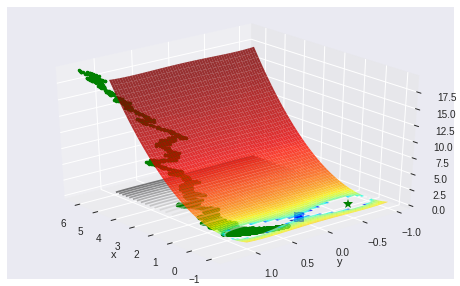

In [0]:
###########################################################################################    
gd_plot( np.array(cost_nsgd2), np.array(iterate_nsgd2), lam, beta, zeta) 
###########################################################################################

Note that using the initialization $[6,1]$ all methods converge to a global minimizer.


# 4 Reproducing the MNIST result [1]
<a id="mnist"></a>

## Deep Fully-Connected Networks
We reproduce the MNIST experiment in the Section 4.1 of the paper. There are two main claims in the paper regarding the benefit of the proposed additive noise method. First, it is useful for very deep neural networks. Second, it is useful when weights are poorly initialized. Hence, we are motivated to confirm these two claims. 


## Experimental setup
We used the same architecture described in the paper: a 20 hidden-layer feedforward neural network with ReLU activation functions. We compare the performance of with-noise and without-noise models for the three initialization schemes: Good Init, Simple Init and Bad Init. We use Stochastic Gradient Descent, i.e. a single sample is used to compute a gradient at every iteration.


*   Good Init: we use He initialization (He et al., 2015),
*   Simple Init: $w_{\text{init}} \sim \mathcal{N}(0, \sigma^2),$
*   Bad init: $w_{\text{init}} = 0.$

For computational reasons, we slightly modified the experimental setup such that we chose $\sigma$ of Simple Init to be 1.0 instead of 0.1 and applied weight regularization with the l2 weight decay of 0.01 for Simple Init and 0.001 for Bad Init. We noticed the values of the weights are nearly zero at the early stage of training under Simple Init and Bad Init (with noise) and hence, the gradients are small that it takes a long time to reach a target accuracy. Without the modifications, we observed improvement of performance with the noise, as reported in the paper with a slow convergence.

## Results

We confirmed that adding noise helps overcome bad initialization. Especially when weights are initialized to be zero, the benefit is clearly pronounced. This is because noise helps break the bad symmetry (or, uniformity) in backpropagation. Under zero initialization, the logit prediction over all classes will necessarily be the same and therefore, the gradient update will take place symmetrically over all weights in each layer. Without noise, the accuracy will be as good as the uniform classifier which gives an expected accuracy of 10% (since there are 10 classes in this problem).     

We present below the training and test accuracies, where experiments are labeled as in [1].

<div class="alert alert-block alert-info">Note: due to limited computational resources, we show the results of our experiments below with a single trial for each experiment. We indeed ran the experiments for multiple times (which produces similiar results as in the paper) but due to computational constraints, did not have the time to produce plots for many experiments.</div>


## Reproducing Experiment 5 (Good init)

When weights are initialized in a good region of its cost function, adding noise is not particularly helpful.

### SGD without noise

We observe the validation accuarcy of approximately 95%. 
![exp5_sgd](https://s3.amazonaws.com/harvard-dh/am207/exp5_sgd_train_loss.png)
![exp5_sgd](https://s3.amazonaws.com/harvard-dh/am207/exp5_sgd_val_accuracy.png)



### SGD with noise
We observe the validation accuarcy of approximately 96%. 

![exp5_sgd](https://s3.amazonaws.com/harvard-dh/am207/exp5_sgd_noise_train_loss.png)
![exp5_sgd](https://s3.amazonaws.com/harvard-dh/am207/exp5_sgd_noise_val_accuracy.png)


## Reproducing Experiment 3 (Simple init)
When weights are initialized simply with mean of zero, but with non-zero variance, so most weights may have different values (symmetry breaking), we confirm adding gradient noise helps.


### SGD without noise

We observe validation accuracy of 45%.

![exp3_sgd](https://s3.amazonaws.com/harvard-dh/am207/exp3_sgd_train_loss.png)

![exp3_sgd](https://s3.amazonaws.com/harvard-dh/am207/exp3_sgd_val_accuracy.png)



### SGD with noise

We observe validation accuracy of 80%.

![exp3_sgd_noise](https://s3.amazonaws.com/harvard-dh/am207/exp3_sgd_noise_train_loss.png)

![exp3_sgd_noise](https://s3.amazonaws.com/harvard-dh/am207/exp3_sgd_noise_val_accuracy.png)


## Reproducing Experiment 6 (Bad init)
When weights get initialized to zero, the gradient updates take place symmetrically across all weights in each layer and prevent the network from learning.  

### SGD without noise

We observe the validation accuracy of 10%.

![exp6_sgd](https://s3.amazonaws.com/harvard-dh/am207/exp6_sgd_train_loss.png)

![exp6_sgd](https://s3.amazonaws.com/harvard-dh/am207/exp6_sgd_val_accuracy.png)

### SGD with noise

We observe the validation accuracy of 20%. Though this may not seem like significant improvement, we would like to remark that had we run for more epochs, we would have seen better improvement.

![exp6_sgd](https://s3.amazonaws.com/harvard-dh/am207/exp6_sgd_noise_train_loss.png)

![exp6_sgd](https://s3.amazonaws.com/harvard-dh/am207/exp6_sgd_noise_val_accuracy.png)



# 5. Source Code
<a id="source"></a>
The full source code can be found at (also in the attachment): https://git.io/vpu0T

Assuming the script called "main.py" is in the same directory as this jupyter notebook file, one can run the experiments by simply executing the cell below. Note the source code has been implemented from scratch. 


In [0]:
# Experiment 3
# SGD 
! python3 main.py --batch_size 1 --init_weight_type "simple" --exp_id "exp3_sgd" --grad_clip --grad_clip_value 10.0 --lr 0.1 --simple_init_std 1.0 --weight_decay 0.01 --n_epoch 1

# experiment 3
# SGD w/ noise
! python3 main.py --batch_size 1 --grad_noise --eta 0.01 --gamma 0.55 --init_weight_type "simple" --exp_id "exp3_sgd_noise" --grad_clip --grad_clip_value 10.0 --lr 0.1 --simple_init_std 1.0 --weight_decay 0.01

# experiment 5

# SGD 
! python3 main.py --batch_size 1 --grad_clip --grad_clip_value 10.0 --init_weight_type "good" --exp_id "exp5_sgd" --lr 0.1
# experiment 5

# SGD w/ noise
! python3 main.py --batch_size 1 --grad_noise --eta 0.01 --grad_clip --grad_clip_value 10.0 --init_weight_type "good" --exp_id "exp5_sgd_noise" --lr 0.1

# Experiment 6
# SGD 
! python3 main.py --batch_size 1 --grad_clip --grad_clip_value 10.0 --init_weight_type "bad" --exp_id "exp6_sgd" --lr 0.1 --weight_decay 0.001

# Experiment 6
# SGD w/ noise
! python3 main.py --batch_size 1 --grad_noise --eta 1.0 --grad_clip --grad_clip_value 10.0 --init_weight_type "bad" --exp_id "exp6_sgd_noise" --lr 0.1 --weight_decay 0.001

# 6. References
<a id="reference"></a>

[1] A. Neelakantan, L. Vilnis, Q. V. Le, I. Sutskever, L. Kaiser, K. Kurach and J. Martens, "Adding Gradient Noise Improves Learning for Very Deep Networks."	arXiv preprint arXiv:1511.06807 (2015).

[2] S. S. Du, C. Jin, J. D. Lee, M. I. Jordan, B. Poczos and A. Singh. Gradient Descent Can Take Exponential Time to Escape Saddle Points. In Advances in Neural Information Processing Systems, (NIPS 2017).

[3] R. Ge, F. Huang, C. Jin and Y. Yuan. Escaping From Saddle Points - Online Stochastic Gradient for Tensor Decomposition. arXiv preprint arXiv:abs/1503.02101 (2015).

[4] Y-X. Yuan. A review of trust region algorithms for optimization.

[5] S. Boyd and L. Vandenberghe, Convex Optimization. Cambridge University Press, 2004.

[6] S. J. Reddi, M. Zaheer, Su. Sra, B. Poczos, F. R. Bach,  R. Salakhutdinov and A. J. Smola. A Generic Approach for Escaping Saddle points. arXiv preprint arXiv:abs/1709.01434 (2017).

[7] C. Jin, R. Ge, P. Netrapalli, S. M. Kakade and M. I. Jordan. How to Escape Saddle Points Efficiently. arXiv preprint arXiv:1703.00887 (2017).

[8] J. Sun, Q. Qu, and J. Wright. A Geometric Analysis of Phase Retrieval. arXiv preprint arXiv:abs/1602.06664 (2016).

[9] J. Sun, Q. Qu, and J. Wright. Complete Dictionary Recovery over the Sphere I: Overview and the Geometric Picture. arXiv preprint arXiv:1511.03607 (2016).

[10] M. Welling and Y. W. Teh. "Bayesian learning via stochastic gradient Langevin dynamics." Proceedings of the 28th International Conference on Machine Learning (ICML-11)  (2011).

[11] L. Balles , J. Romero, and P. Hennig. "Coupling adaptive batch sizes with learning rates." arXiv preprint arXiv:1612.05086 (2016).

[12] L. Bottou "Stochastic gradient learning in neural networks." Proceedings of Neuro-Nımes, (1991).

[13] J. D. Lee, M. Simchowitz, M. I. Jordan and B. Recht. "Gradient Descent Converges to Minimizers." arXiv preprint arXiv:1602.04915 (2016).

[14] J. Bourrely "Parallelization of a neural network learning algorithm on a hypercube." Hypercube and distributed computers. Elsiever Science Publishing (1989).

[15] Ian J. Goodfellow, Oriol Vinyals, and Andrew M. Saxe. "Qualitatively characterizing neural network optimization problems." arXiv preprint arXiv:1412.6544 (2014).

[16] Hao Li, Zheng Xu, Gavin Taylor, and Tom Goldstein. "Visualizing the Loss Landscape of Neural Nets." arXiv preprint arXiv:1712.09913 (2017).

